In [1]:
!pip install transformers
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 3.7 MB/s eta 0:00:00


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00


In [3]:
!pip install accelerate -U
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.5 MB/s eta 0:00:00


In [4]:
#Import Libraries
import os

#Data manipulation
import pandas as pd
import numpy as np
import datasets
from sklearn.model_selection import train_test_split
import collections
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns

#finetuning
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
import torch
from torch.utils.data import DataLoader

#Evaluation
from datasets import load_metric, load_dataset
from sklearn.metrics import f1_score
from huggingface_hub import notebook_login

# Statistics
from scipy.stats import chi2_contingency

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
#login to huggingface
notebook_login()

In [14]:
os.environ["WANDB_DISABLED"] = "false"

# Load The Datasets

In [15]:
#load data
train_df = pd.read_csv('/content/drive/MyDrive/Movie_Datasets/Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Movie_Datasets/Test.csv')

In [16]:
# Check the train dataset
train_df

,review_file,content,sentiment
0,3471_8.txt,Recently shown on cable tv the movie opens wit...,positive
1,9693_8.txt,I was very surprised with this film. I was tou...,positive
2,10801_1.txt,"Now, I'm one to watch movies that got poor rev...",negative
3,9592_8.txt,"This film came out 12 years years ago, and was...",positive
4,8514_7.txt,"When an orphanage manager goes on vacation, hi...",positive
...,...,...,...
24995,2791_3.txt,"As with most of the reviewers, I saw this on S...",negative
24996,644_9.txt,A have a female friend who is currently being ...,positive
24997,4921_8.txt,Like A Streetcar Named Desire (also directed b...,positive
24998,5791_1.txt,"As a Native film professor, I can honestly say...",negative


In [17]:
# Check the Test dataset
test_df

,review_file,content
0,0_10.txt,I went and saw this movie last night after bei...
1,0_2.txt,Once again Mr. Costner has dragged out a movie...
2,10000_4.txt,This is an example of why the majority of acti...
3,10000_7.txt,Actor turned director Bill Paxton follows up h...
4,10001_1.txt,"First of all I hate those moronic rappers, who..."
...,...,...
24995,999_8.txt,"From the start of ""The Edge Of Love"", the view..."
24996,99_10.txt,"This movie, with all its complexity and subtle..."
24997,99_3.txt,Four things intrigued me as to this film - fir...
24998,9_4.txt,David Bryce's comments nearby are exceptionall...


In [18]:
# View information about Train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_file  25000 non-null  object
 1   content      25000 non-null  object
 2   sentiment    25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


## Remove the rows with null values in the sentiment column of the train_df DataFrame

In [19]:
# Remove rows with null values
train_df.dropna(subset=['sentiment'], inplace=True)

In [20]:
# View info once again from Train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_file  25000 non-null  object
 1   content      25000 non-null  object
 2   sentiment    25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


## View the stucture of the 'content' column

In [21]:
#look at some of the tsentences and how they are written
for sentence in range(10):
    sentence_str=train_df['content'][sentence]
    print(f'{sentence_str}\n')

Recently shown on cable tv the movie opens with a disclaimer distancing itself from any co-operation of real life persons; that in itself is an eye catcher. Yet the script and acting from the main characters is superb and I found myself engrossed throughout.Due in no small way to the crisp, thoughtful and interesting dialogue.The film is about a meeting on one day between two real life musical "legends" who formerly composed together then seperated.The film captures the essence of their lives and philosophies, in a story which proffers an explanation for their initial "split". What is so impressive is that the actors give such seemingly realistic portrayals of the characters they play,faults and all, that this viewer at least was left believing I was witnessing a true event in almost every detail. The great skill of this play is that with astute writing and fine acting a movie basically about "two of us" talking can make an excellent picture. Worthy of at least an 8 out of 10.

I was v

### Findings
- Some sentences contain &lt;br/&gt;&lt;br/&gt; tags
- Most sentences are just plain text

# Exploratory Data analysis
  1. Use wordcloud to look at the most words appearing
  2. Most used words

## Visualize frequent words using wordcloud

In [22]:
# Generate a word cloud from the message text data
text = " ".join(sentence for sentence in train_df.content)
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white")
# Generate the word cloud
wordcloud.generate(text)

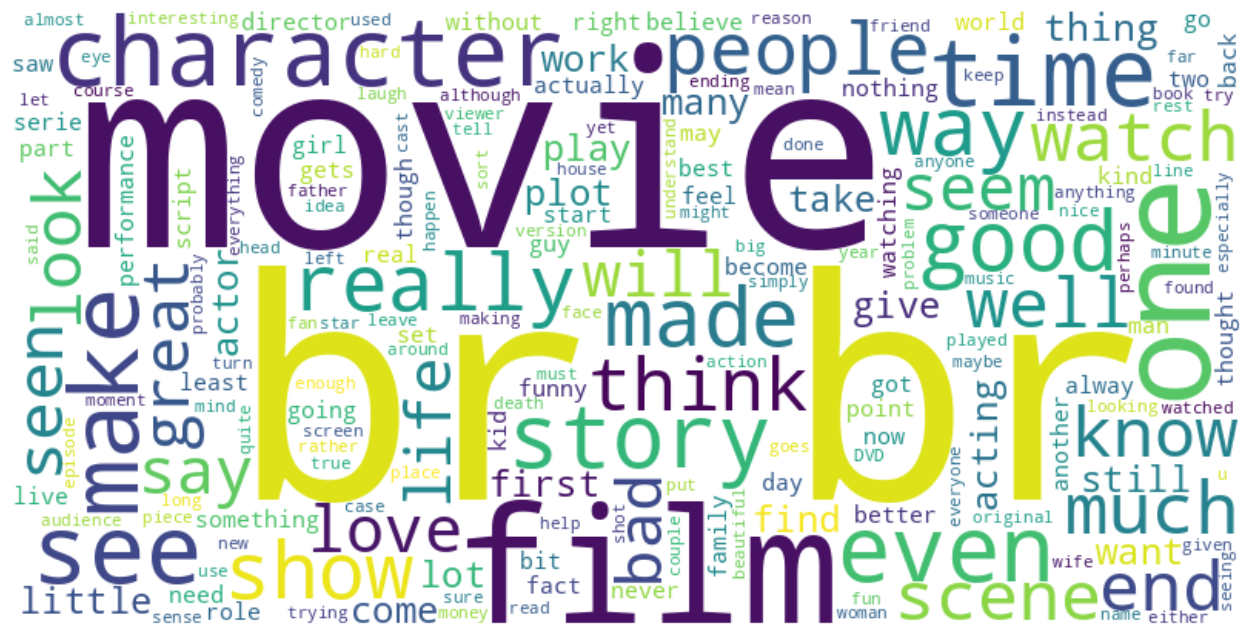

In [23]:
# Display the word cloud image
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## &lt;br/&gt;&lt;br/&gt; tags won't be relevant to our analysis so lets remove them

In [24]:
#replace <br/><br/> tags in the dataset
train_df['content']=train_df['content'].replace({'br':''},regex=True)

In [25]:
# Generate a word cloud from the message text data
text = " ".join(sentence for sentence in train_df.content)
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white")
# Generate the word cloud
wordcloud.generate(text)

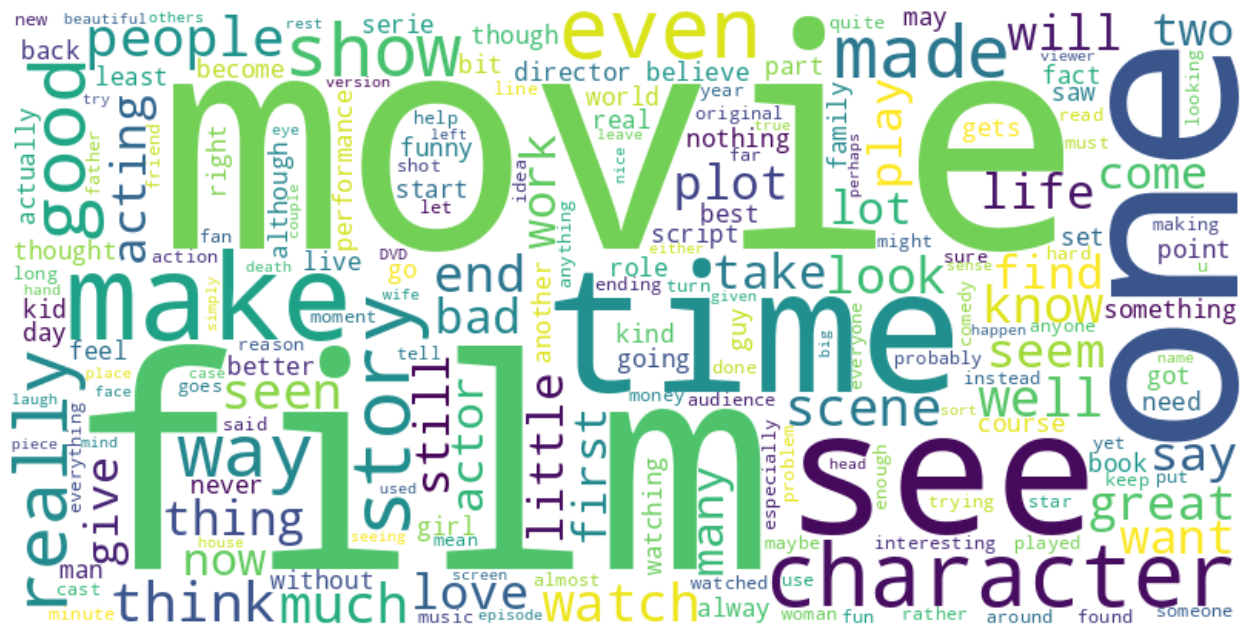

In [26]:
# Display the word cloud image
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From the above wordcloud, the observation is that "movie" and "film" words are the largest in size indicates that these words are likely among the most frequently mentioned words in the text.

# Remove stop words

In [27]:
# Download NLTK stop words if not already downloaded
nltk.download("stopwords")

# Load the English stop words
stop_words = set(stopwords.words("english"))


# Remove stop words from the 'content' column and store the result in a new column
train_df["content_without_stopwords"] = train_df["content"].apply(
    lambda text: " ".join(word for word in text.split() if word.lower() not in stop_words)
)

# Display the updated DataFrame
train_df["content_without_stopwords"].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    Recently shown cable tv movie opens disclaimer...
1    surprised film. touched lives paulie touched a...
2    Now, I'm one watch movies got poor reviews, sa...
3    film came 12 years years ago, revelation even ...
4    orphanage manager goes vacation, father takes ...
Name: content_without_stopwords, dtype: object

## Let's check word Frequency again using barcharts

In [28]:
# Combine all sentences
sentence = " ".join(train_df["content_without_stopwords"].astype(str))

# Split the string into a list of words ignoring special characters
words = re.findall(r'\b\w+\b', sentence)

# Convert all words to lowercase
words = [word.lower() for word in words]

# Count the occurrences of each word using Counter
word_counts = collections.Counter(words)

# Combine words that differ only with 's' at the end
combined_words = []
for word in words:
    if word.endswith('s') and len(word) > 1:
        singular_word = word[:-1]
        if singular_word in word_counts:
            combined_words.append(singular_word)
        else:
            combined_words.append(word)
    else:
        combined_words.append(word)

# Recount the occurrences of each word using Counter
word_counts = collections.Counter(combined_words)

# Get the top 20 most common words and their counts
top_words = dict(word_counts.most_common(20))

top_words

{'movie': 51715,
 'film': 47048,
 's': 46233,
 'one': 27748,
 'like': 20747,
 'i': 20372,
 'time': 15969,
 'it': 15211,
 'good': 15204,
 'the': 14551,
 'character': 14183,
 'even': 12655,
 'get': 12515,
 'would': 12436,
 'make': 12229,
 'see': 12016,
 'story': 11991,
 'really': 11738,
 'well': 10788,
 'scene': 10596}

## Visualize word frequency using bar chart

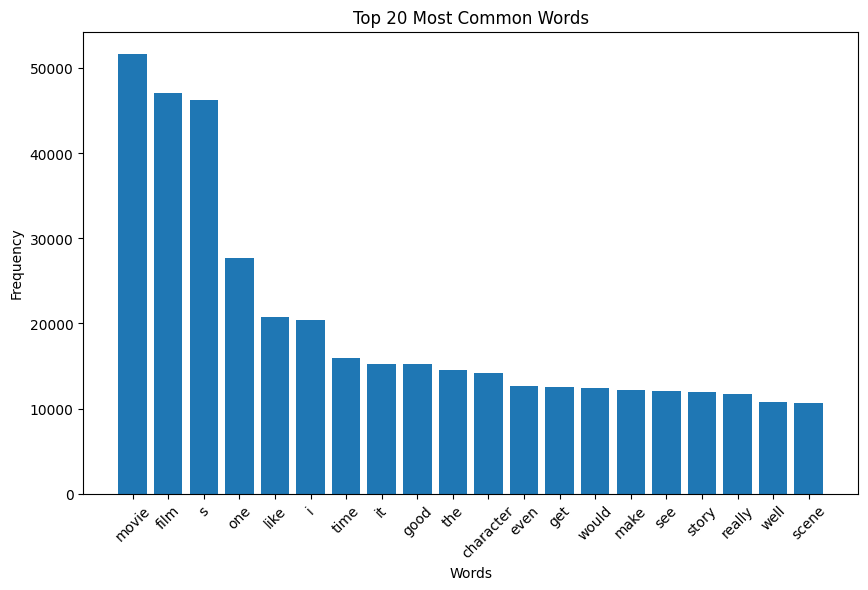

In [29]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

## Distribution of Sentiment Labels

In [30]:
# Calculate the frequency of each sentiment label
label_counts = train_df['sentiment'].value_counts()
label_counts

positive    12500
negative    12500
Name: sentiment, dtype: int64

## Visualize the distribution of the sentiment labels

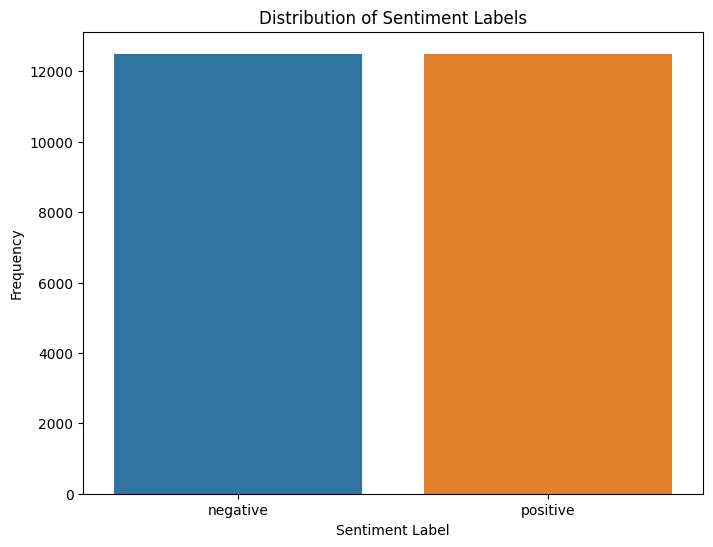

In [31]:
train_df['sentiment'] = train_df['sentiment'].astype('category')
# Create a bar chart to visualize the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=train_df['sentiment'].value_counts().index, y=train_df['sentiment'].value_counts().values)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.show()

From the graph, we see that the sentiments are perfectly balanced.

## Perform text length analysis on the "content" column

In [32]:
# Calculate the length of each text in the "content" column
text_lengths = train_df['content'].apply(len)

# Compute descriptive statistics of text lengths
text_length_stats = text_lengths.describe()

# Print the descriptive statistics
print(text_length_stats)

count    25000.000000
mean      1315.717400
std        995.816476
min         52.000000
25%        699.000000
50%        973.000000
75%       1602.000000
max      13632.000000
Name: content, dtype: float64


The above summary statistics tell us that:
- **count**: The total number of texts in the column, which is 25,000.
- **mean**: The average length of the texts is approximately 1315.72 characters.
- **std**: The standard deviation of the text lengths is approximately 995.82, indicating the variability in the lengths.
- **min**: The shortest text has a length of 52 characters.
- **25%**: The 25th percentile (lower quartile) of text lengths is 699 characters, meaning that 25% of the texts have lengths less than or equal to 699 characters.
- **50%**: The median text length is 973 characters, which means that half of the texts have lengths less than or equal to 973 characters.
- **75%**: The 75th percentile (upper quartile) of text lengths is 1602 characters, indicating that 75% of the texts have lengths less than or equal to 1602 characters.
- **max**: The longest text has a length of 13632 characters.

## Visualize the distribution of text lengths using histograms or box plots.

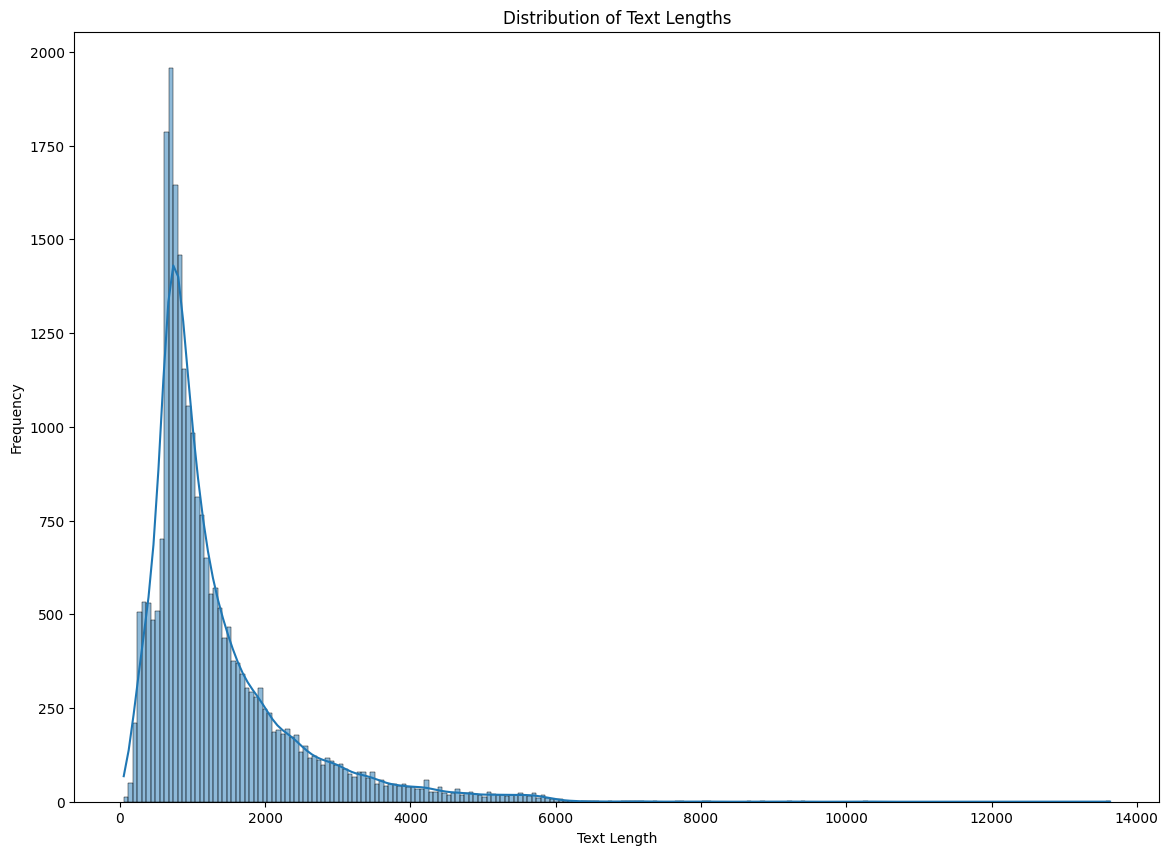

In [33]:
# Create a histogram to visualize the distribution of text lengths
plt.figure(figsize=(14, 10))
sns.histplot(text_lengths, kde=True)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

From the histogram:

1. The distribution appears to be right-skewed, indicating that there are relatively few texts with very short lengths and a larger number of texts with longer lengths.
2. The majority of texts seem to fall within the range of around 500 to 2000 characters.
3. As text length increases beyond this range, the frequency of texts decreases significantly.
4. The KDE (kernel density estimation) plot provides additional smoothness to the distribution, allowing us to observe trends and modes more easily.

## Boxplot of sentence lengths distribution

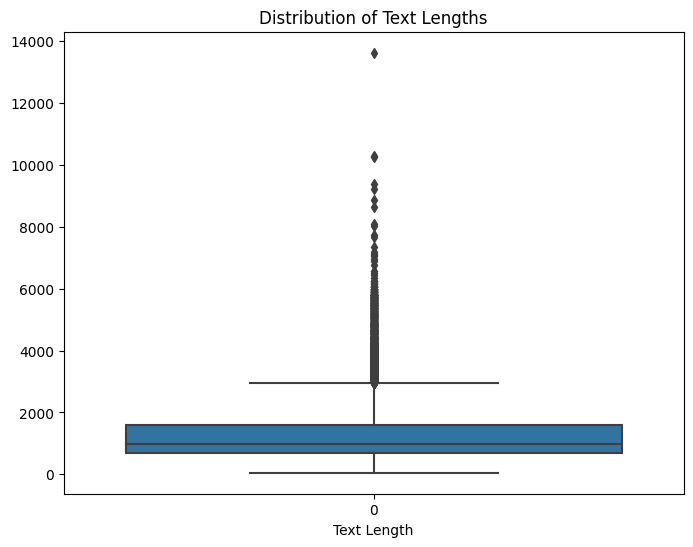

In [34]:
# Create a box plot to visualize the distribution of text lengths
plt.figure(figsize=(8, 6))
sns.boxplot(text_lengths)
plt.xlabel('Text Length')
plt.title('Distribution of Text Lengths')
plt.show()

In this specific box plot:

- The box represents the interquartile range (IQR), which contains the middle 50% of the data.
- The bottom edge of the box indicates the 25th percentile (Q1), and the top edge indicates the 75th percentile (Q3).
- The horizontal line inside the box represents the median (50th percentile).
- The "whiskers" extend from the edges of the box to the minimum and maximum values within a certain range. Data points outside this range are considered potential outliers and are plotted individually as dots.
- The dots above the whiskers are individual data points that are considered outliers.

## Analyze the association between the sentiment labels and multiple keywords "movie", "movies", "film", "films", "character", "make", "even", "one" and "show"

In [35]:
# Create keyword columns
keywords = ['movie', 'movies', 'film', 'films', 'character', 'make', 'even', 'one', 'show']
for keyword in keywords:
    train_df[keyword] = train_df['content'].str.contains(keyword, case=False).astype(int)

# Combine occurrences of 'movie' and 'movies'
train_df['movies_combined'] = train_df['movie'] + train_df['movies']

# Combine occurrences of 'film' and 'films'
train_df['films_combined'] = train_df['film'] + train_df['films']

# Update the keyword list
keywords_updated = ['movies_combined', 'films_combined', 'character', 'make', 'even', 'one', 'show']

# Group the data by sentiment label and calculate keyword frequencies
keyword_frequencies = train_df.groupby('sentiment')[keywords_updated].sum()

# Print the keyword frequencies
keyword_frequencies


,movies_combined,films_combined,character,make,even,one,show
sentiment,,,,,,,
negative,11583,9550,4201,5078,5745,9685,2905
positive,10042,10146,4270,4387,4542,9478,3408


## Keyword Frequencies by Sentiment Label
The chart allows us to compare the distribution and relative frequencies of keywords across different sentiment categories.

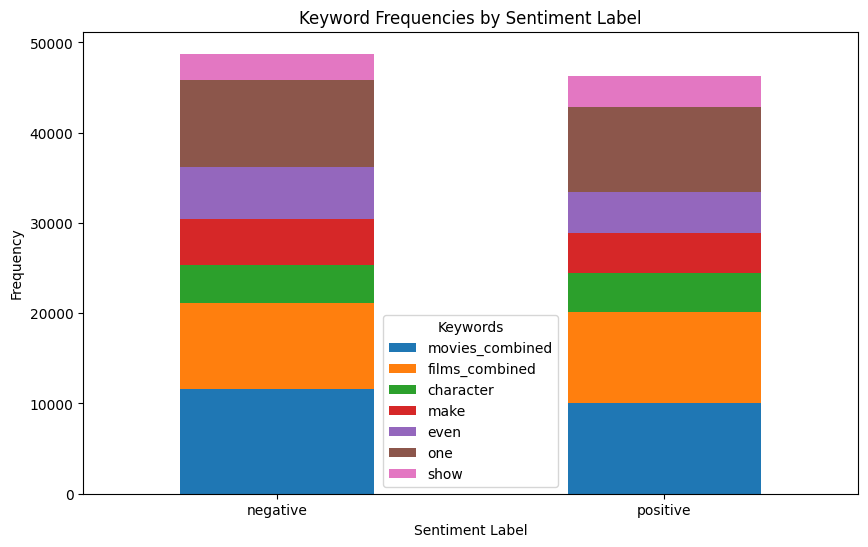

In [36]:
# Set the labels for the sentiment labels
sentiment_labels = ['negative', 'positive']

# Plot the stacked bar chart
keyword_frequencies.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set the labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Keyword Frequencies by Sentiment Label')

# Show the legend
plt.legend(title='Keywords')

# Set the x-axis tick labels as the sentiment labels
plt.xticks(range(len(sentiment_labels)), sentiment_labels, rotation=0)

# Show the plot
plt.show()

We can conclude that these commonly used words in the sentences are almost uniformly distributed in their usage between the two sentiments with a slightly more usage of the word(s) movie(s) in negative sentiment.

In [37]:
# Drop "content_without_stopwords" column from train_df
train_df.drop(columns=["content_without_stopwords"], inplace=True)

# Revert to original Dataset

In [39]:
train_df.drop(train_df.columns.difference(['review_file', 'content', 'sentiment']), axis=1, inplace=True)

In [40]:
train_df

,review_file,content,sentiment
0,3471_8.txt,Recently shown on cable tv the movie opens wit...,positive
1,9693_8.txt,I was very surprised with this film. I was tou...,positive
2,10801_1.txt,"Now, I'm one to watch movies that got poor rev...",negative
3,9592_8.txt,"This film came out 12 years years ago, and was...",positive
4,8514_7.txt,"When an orphanage manager goes on vacation, hi...",positive
...,...,...,...
24995,2791_3.txt,"As with most of the reviewers, I saw this on S...",negative
24996,644_9.txt,A have a female friend who is currently being ...,positive
24997,4921_8.txt,Like A Streetcar Named Desire (also directed b...,positive
24998,5791_1.txt,"As a Native film professor, I can honestly say...",negative


In [41]:
#check for the presence of null values again
train_df.isna().sum()

review_file    0
content        0
sentiment      0
dtype: int64

## Split the Train the dataset into training(for learning ) and evaluation (for computing metrics to capture overfitting) sets

In [42]:
train , eval = train_test_split(train_df,train_size=0.8,stratify=train_df['sentiment'], random_state=42)


### Check the train dataset

In [43]:
train.head()

,review_file,content,sentiment
15006,2717_10.txt,"I can't remember many details about the show, ...",positive
10110,4651_3.txt,"Of course, ""Flatley"" is already not exactly th...",negative
24523,7005_9.txt,When its DVD was released i came to market and...,positive
2452,12364_7.txt,"Cashing in on the ""demons-meets-clergy"" trend ...",positive
15936,8950_7.txt,For those of you unfamiliar with Jimmy Stewart...,positive


### Check the eval dataset

In [44]:
eval.head()

,review_file,content,sentiment
6106,852_7.txt,THE MATADOR is hit-man movie lite....if you ca...,positive
12473,10234_10.txt,"< />< />""Burning Paradise"" is a combination of...",positive
17907,7814_4.txt,"After a long period in the space, looking for ...",negative
8153,11008_1.txt,I bought this at tower records after seeing th...,negative
5431,3126_10.txt,I don't hand out ten star ratings easily. A mo...,positive


### Check the shapes of both datasets

In [45]:
print(f'Shape of training set: {train.shape}\nShape of evaluation set: {eval.shape}')

Shape of training set: (20000, 3)
Shape of evaluation set: (5000, 3)


## Save the splitted data to be loaded as huggingface dataset

In [58]:
# Save splitted subsets
train.to_csv("/content/drive/MyDrive/Movie_Datasets/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Movie_Datasets/eval_subset.csv", index=False)

## Load the datasets

In [59]:
datasets = load_dataset('csv',
                        data_files={'train':'/content/drive/MyDrive/Movie_Datasets/train_subset.csv',
                        'eval':'/content/drive/MyDrive/Movie_Datasets/eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

## Creating a Tokenizer instance
- The line of code below initializes a tokenizer for the "sentence_sentiments_analysis_distilbert" model using the transformers library. The tokenizer is an essential component for processing text data and is used to convert input text into tokens that can be fed into the model for sentiment analysis.

In [61]:
#Create a tokenizer instance
tokenizer=AutoTokenizer.from_pretrained('bert-base-cased')

In [62]:
# Chunk size for dividing longer sequences
chunk_size = 512  # Adjust this based on the length of the tokens

## Functions to tokenize text and transform labels

The functionality of these two functions:

1. **tokenize_data(data)**: This function takes a dictionary-like data object as input, which is assumed to have a 'content' field containing the text to be tokenized. Here's how the function works:

  - **content = data['content']**: This line extracts the 'content' field from the input dictionary and assigns it to the variable content.
  - **tokens = tokenizer(content, padding='max_length', truncation=True, max_length=chunk_size, return_tensors='pt')**: This line uses the Hugging Face tokenizer to tokenize the content text. The padding='max_length' argument ensures that the sequences are padded to the specified max_length (assuming max_length is defined elsewhere in the code). The truncation=True argument truncates sequences that exceed the max_length. The max_length=chunk_size argument specifies the maximum length of the tokenized sequence. The return_tensors='pt' argument indicates that the output should be returned as PyTorch tensors.
  - **return tokens**: The function returns the tokenized representation of the text content as a dictionary of PyTorch tensors, which includes the token IDs, attention masks, and other relevant information.
2. **transfom_label(data)**: This function takes a dictionary-like data object as input, which is assumed to have a 'sentiment' field containing the sentiment label ('positive' or 'negative'). Here's how the function works:

  - **label = data['sentiment']**: This line extracts the 'sentiment' field from the input dictionary and assigns it to the variable label.
  - The function then uses a simple conditional logic to transform the sentiment label into a numeric label:
    - If the label is 'negative', the function assigns the value 0 to the variable num.
    - If the label is 'positive', the function assigns the value 1 to the variable num.
  - The function then returns a dictionary with the label information in the format expected by the model. In this case, the key is 'labels', and the value is the numeric label (0 for 'negative' and 1 for 'positive').

In [63]:
def tokenize_data(data):
    content = data['content']
    tokens = tokenizer(content, padding='max_length', truncation=True, max_length=chunk_size, return_tensors='pt')
    return tokens


#function to transform labels
def transfom_label(data):

    #extract label
    label=data['sentiment']
    num=0
    #create contitions
    if label=='negative':
        num=0
    else:
        num=1      #Positive
    return {'labels':num}

## Tokenizer text and trasform original sentiment labels

The code below involves processing and preparing text data for a machine learning model using the Hugging Face datasets library. Here's a step-by-step explanation of the code:

1. **remove_columns = ['review_file', 'content', 'sentiment']**: This line defines a list named remove_columns that contains the names of columns that need to be removed from the dataset after tokenization and label transformation. The columns 'review_file', 'content', and 'sentiment' are specified, likely because these columns are not needed in their current form after the data preprocessing steps.

2. **datasets = datasets.map(tokenize_data, batched=True)**: This line applies the tokenize_data function to each data point (sample) in the datasets object using the .map() function. The tokenize_data function takes the content of the 'content' column and tokenizes it using a tokenizer. The batched=True parameter indicates that the function should be applied to the entire dataset in batches rather than individual data points. This function essentially tokenizes the text data and stores the tokenized representations in the dataset.

3. **datasets = datasets.map(transfom_label, remove_columns=remove_columns)**: After tokenization, this line further processes the dataset using the transfom_label function and removes the columns specified in the remove_columns list. The transfom_label function takes the 'sentiment' column and transforms its values to numeric labels. The remove_columns=remove_columns parameter ensures that the specified columns are removed from the dataset.

In [64]:
#The following columns will be removed after tokenization
remove_columns = ['review_file', 'content', 'sentiment']

#Tokenize the text data
datasets = datasets.map(tokenize_data, batched=True)

#transform the labels
datasets=datasets.map(transfom_label,remove_columns=remove_columns)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

## Extract the train and eval datasets from datasets

The code below does the following:

1. **train_dataset=datasets['train'].shuffle(seed=42)**: This line extracts the training dataset from the larger datasets object. The datasets object appears to be a dictionary-like structure that contains different subsets of data, such as "train" and "eval" (evaluation) datasets. The .shuffle(seed=42) function is applied to the training dataset, which means that the data points within the training dataset will be randomly shuffled. The seed parameter is set to 42 to ensure that the random order remains the same across different runs of the code (for reproducibility).

2. **eval_dataset=datasets['eval'].shuffle(seed=42)**: Similarly, this line extracts the evaluation dataset from the datasets object and shuffles its data points using the same seed=42. This step ensures that the evaluation dataset is also shuffled in the same way as the training dataset, maintaining consistency between the two datasets.

In [65]:
#extract train datasets
train_dataset=datasets['train'].shuffle(seed=42)
#extract eval datasets
eval_dataset=datasets['eval'].shuffle(seed=42)

## Define Metrics Function

The code below does the following:

1. **logits**: This array contains the predicted scores or probabilities for each class produced by the model. Each row corresponds to a data point, and each column corresponds to a class. The values in the logits array indicate how strongly the model believes each class is present in the data point.

2. **labels**: This array contains the true labels or ground truth for each data point. These are the actual classes to which the data points belong.

3. **predictions**: The np.argmax function is used to find the index of the highest predicted score (probability) in the logits array for each data point. This index corresponds to the predicted class label for that data point.

4. **f1_score(labels, predictions, average='weighted')**: This computes the F1-score using the f1_score function from the sklearn.metrics module. The F1-score is a metric that combines precision and recall to provide a balanced measure of a model's accuracy. It's particularly useful when dealing with imbalanced classes.

5. **return {"f1-score": f1}**: The function returns a dictionary containing the calculated F1-score with the key "f1-score". This format is suitable for reporting and tracking multiple metrics during model evaluation.

In [66]:
# Define the function to compute F1-score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

## Three models shall be trained in turns as follows:
1. 'bert-base-cased' and be named as: 'sentence_sentiments_analysis_bert'
2. 'distilbert-base-cased' and be named as: 'sentence_sentiments_analysis_distilbert'
3. 'roberta-base' and be named as: 'sentence_sentiments_analysis_roberta'

## Set the training argumets

- In summary, the TrainingArguments object is used to define various training configurations and hyperparameters, such as the number of training epochs, evaluation and saving strategies, and whether to push the model to the Hugging Face Model Hub after training. This object is then passed to the Trainer class for model training using the specified settings

In [67]:
#set the training arguments
trainargs=TrainingArguments('sentence_sentiments_analysis_bert',
                            num_train_epochs=5,
                            evaluation_strategy="epoch",
                            save_strategy='epoch',
                            load_best_model_at_end=True,
                            push_to_hub=True)

## Create an instance of the Model

- The code below creates a pre-trained sequence classification model with three output labels and initializes it with the pre-trained weights from the model. This model can be fine-tuned for a specific classification task, such as sentiment analysis, with the appropriate training data.

In [68]:
# Create an instance of the BERT model
model_name = 'bert-base-cased'
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create trainer instance

- The code below creates a Trainer instance with the necessary components, including the model, training and evaluation datasets, tokenizer, and a function for computing evaluation metrics. The Trainer instance can be used to train and evaluate the pre-trained sequence classification model on the specified datasets using the defined training arguments.

In [72]:
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=trainargs,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    )

## Start training

- The code below trainer.train() is used to initiate the training process of the pre-trained sequence classification model using the specified training dataset and training arguments. When this code is executed, the model will start training for the specified number of epochs (defined in the training arguments) on the provided training dataset.

In [ ]:
trainer.train()

## Evaluate model

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print("Bert model:")
print("Evaluation results:", results)

# Push model to huggingface

In [ ]:
trainer.push_to_hub()

## Load the Pretrained Model:

In [12]:
# Load the pre-trained models
model_names = {
    'Bert': 'UholoDala/sentence_sentiments_analysis_bert',
    'Distilbert': 'UholoDala/sentence_sentiments_analysis_distilbert',
    'Roberta': 'UholoDala/sentence_sentiments_analysis_roberta'
}

# Create empty dictionaries to store the models
models = {}

for model_name, model_path in model_names.items():
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    models[model_name] = (model, tokenizer)

# Text Tokenization

The code below is responsible for tokenizing the text data in your test_df DataFrame and adding the tokenized input IDs and attention masks to the DataFrame as new columns. Let's break down what each part of the code is doing:

1. **Initialize Empty Lists**: input_ids and attention_masks are two empty lists that will be used to store the tokenized input IDs and attention masks for each text in the test dataset.

2. **Iterate Through Test Data**: The code uses a for loop to iterate through each row in the test_df DataFrame. For each row, it extracts the 'content' column value (the text to be tokenized) into the variable text.

3. **Tokenize the Text**: Inside the loop, the tokenizer is used to tokenize the text using the tokenizer(text, return_tensors='pt', padding=True, truncation=True) function. This function tokenizes the text, converts it into PyTorch tensors, and also handles padding and truncation based on the tokenizer's settings.

4. **Append Tokenized Input IDs and Attention Masks**: After tokenization, the input IDs and attention masks are extracted from the inputs dictionary using inputs['input_ids'] and inputs['attention_mask'], respectively. These tensors are then converted to Python lists using .tolist().

5. **Add to DataFrame**: The tokenized input IDs are added to the 'input_ids' column, and the attention masks are added to the 'attention_mask' column in the test_df DataFrame. This effectively adds two new columns to your DataFrame, containing the tokenized representations of the text data.

*By adding the tokenized input IDs and attention masks to the DataFrame, we are preparing the data for input into a model for sentiment prediction or any other natural language processing (NLP) task that requires tokenized text as input.*

In [13]:
# Initialize empty lists to store tokenized inputs
input_ids = []
attention_masks = []

# Iterate through test data
for idx, row in test_df.iterrows():
    text = row['content']  # 'content' being the column name for text data in test_df

    # Tokenize the text using the tokenizer
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

    # Append tokenized input IDs and attention masks to the respective lists
    input_ids.append(inputs['input_ids'].tolist())
    attention_masks.append(inputs['attention_mask'].tolist())

# Add the tokenized input IDs and attention masks to the test_df DataFrame
test_df['input_ids'] = input_ids
test_df['attention_mask'] = attention_masks

In [14]:
test_df

,review_file,content,input_ids,attention_mask
0,0_10.txt,I went and saw this movie last night after bei...,"[[0, 100, 439, 8, 794, 42, 1569, 94, 363, 71, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,0_2.txt,Once again Mr. Costner has dragged out a movie...,"[[0, 11475, 456, 427, 4, 7860, 1396, 34, 10840...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,10000_4.txt,This is an example of why the majority of acti...,"[[0, 713, 16, 41, 1246, 9, 596, 5, 1647, 9, 81...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,10000_7.txt,Actor turned director Bill Paxton follows up h...,"[[0, 40448, 1224, 736, 1585, 5476, 8962, 3905,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,10001_1.txt,"First of all I hate those moronic rappers, who...","[[0, 10993, 9, 70, 38, 4157, 167, 14628, 10003...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
...,...,...,...,...
24995,999_8.txt,"From the start of ""The Edge Of Love"", the view...","[[0, 7605, 5, 386, 9, 22, 133, 12591, 1525, 34...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
24996,99_10.txt,"This movie, with all its complexity and subtle...","[[0, 713, 1569, 6, 19, 70, 63, 13879, 8, 12405...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
24997,99_3.txt,Four things intrigued me as to this film - fir...,"[[0, 22113, 383, 28622, 162, 25, 7, 42, 822, 1...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
24998,9_4.txt,David Bryce's comments nearby are exceptionall...,"[[0, 8773, 16077, 18, 1450, 3027, 32, 20135, 1...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


# Make Predictions:

- **Run the code below (x3), once for every model to get the predictions**
-  **Just change the "model_name" to either:**
    - <u>*Bert, Distilbert or Roberta*</u> then run the code.

The code below defines a function predict_sentiment that predicts the sentiment (positive or negative) of a given text using a pre-trained model and a tokenizer. It then applies this function to each text in the test_df DataFrame to predict sentiments for all the texts. Let's break down the code step by step:

1. **predict_sentiment Function:**

    - This function takes three arguments: text, model, and tokenizer.
    - text: The input text for which sentiment is to be predicted.
    - model: A pre-trained model for sentiment classification.
    - tokenizer: The tokenizer used to tokenize the text for model input.

2. **Tokenize the Text:**

    - Inside the function, the text is tokenized using the provided tokenizer. This tokenization includes converting the text into PyTorch tensors (return_tensors='pt') and handling padding and truncation based on the tokenizer's settings (padding=True, truncation=True).

3. **Make a Prediction Using the Model:**

    - After tokenization, the tokenized text is passed through the model to obtain predictions. The with torch.no_grad(): block is used to ensure that gradients are not computed during this inference step, as it's not needed for prediction.

4. **Extract Predicted Label:**

    - The predicted label is extracted from the model's outputs. It uses torch.argmax(outputs.logits, dim=1).item() to find the class with the highest predicted probability. In this case, it assumes two classes: 0 for negative and 1 for positive sentiment.

5. **Map Numeric Label to 'Negative' or 'Positive':**

    - Depending on the numeric label (0 or 1), it maps it to a human-readable sentiment label: 'negative' or 'positive'.

6. **Iterate Through Test Data:**

    - The code then iterates through each row in the test_df DataFrame using a for loop.

7. **Select Model and Tokenizer:**

    - For each text in test_df, it selects a model and tokenizer based on the model_name. In this code, model_name is set to 'Bert', so it retrieves the corresponding model and tokenizer from the models dictionary.

8. **Predict Sentiment:**

    - The predict_sentiment function is called with the text, model, and tokenizer as arguments, resulting in a sentiment prediction for that text.

9. **Assign Predicted Sentiment:**

    - The predicted sentiment ('negative' or 'positive') is assigned to a new column in test_df named 'predicted_sentiment' for the corresponding text. This column is updated within the loop.

After running this code for all texts in test_df, you'll have a DataFrame test_df that includes a new column 'predicted_sentiment' containing the predicted sentiment for each text in the 'content' column.

In [ ]:
# Define a function to predict sentiment for a given text and model
def predict_sentiment(text, model, tokenizer):
    # Tokenize the text using the tokenizer
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

    # Make a prediction using the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the predicted label (0 for negative, 1 for positive)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    # Map the numeric label to 'negative' or 'positive'
    sentiment = 'negative' if predicted_label == 0 else 'positive'

    return sentiment

# Iterate through the test data and predict sentiment
for idx, row in test_df.iterrows():
    text = row['content']  # 'content' being the column name for text data in test_df
    model_name = 'Bert'  # Choose the model you want to use

    # Get the model and tokenizer for the selected model
    model, tokenizer = models[model_name]

    # Predict sentiment using the predict_sentiment function
    predicted_sentiment = predict_sentiment(text, model, tokenizer)

    # Assign the predicted sentiment to a new column in test_df (i.e., 'predicted_sentiment')
    test_df.at[idx, 'predicted_sentiment'] = predicted_sentiment

# Display predicted sentiments for every model

## 1. **Bert Model**

In [ ]:
# Already predicted sentiments added to 'predicted_sentiment' column
selected_columns = ['review_file', 'predicted_sentiment']
result_df = test_df.loc[:, selected_columns]

# Display 'result_df' contents of only the 'review_file' and 'predicted_sentiment' columns
print('Bert Model:  Predicted Sentiments on Test Data')
print('==============================================')
result_df.head(50)

# Distribution of predicted_sentiment for Bert model

In [ ]:
# Calculate the frequency of each predicted sentiment label
sentiment_counts = test_df['predicted_sentiment'].value_counts()

# Visualization of sentiment_counts for Bert Model


In [ ]:
test_df['predicted_sentiment'] = test_df['predicted_sentiment'].astype('category')
# Create a bar chart to visualize the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=test_df['predicted_sentiment'].value_counts().index, y=test_df['predicted_sentiment'].value_counts().values)
plt.xlabel('Predicted Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Sentiment Labels for Bert Model')
plt.show()

## 2. **Distilbert  Model**

In [ ]:
# Already predicted sentiments added to 'predicted_sentiment' column
selected_columns = ['review_file', 'predicted_sentiment']
result_df = test_df.loc[:, selected_columns]

# Display 'result_df' contents of only the 'review_file' and 'predicted_sentiment' columns
print('Distilbert Model:  Predicted Sentiments on Test Data')
print('==============================================')
result_df.head(50)

Distilbert Model:  Predicted Sentiments on Test Data


,review_file,predicted_sentiment
0,0_10.txt,positive
1,0_2.txt,negative
2,10000_4.txt,negative
3,10000_7.txt,positive
4,10001_1.txt,negative
5,10001_9.txt,positive
6,10002_3.txt,negative
7,10002_8.txt,positive
8,10003_3.txt,positive
9,10003_8.txt,positive


# Distribution of predicted_sentiment for Distilbert model

In [ ]:
# Calculate the frequency of each predicted sentiment label
sentiment_counts = test_df['predicted_sentiment'].value_counts()

In [ ]:
sentiment_counts

negative    12848
positive    12152
Name: predicted_sentiment, dtype: int64

# Visualization of sentiment_counts for Distilbert Model

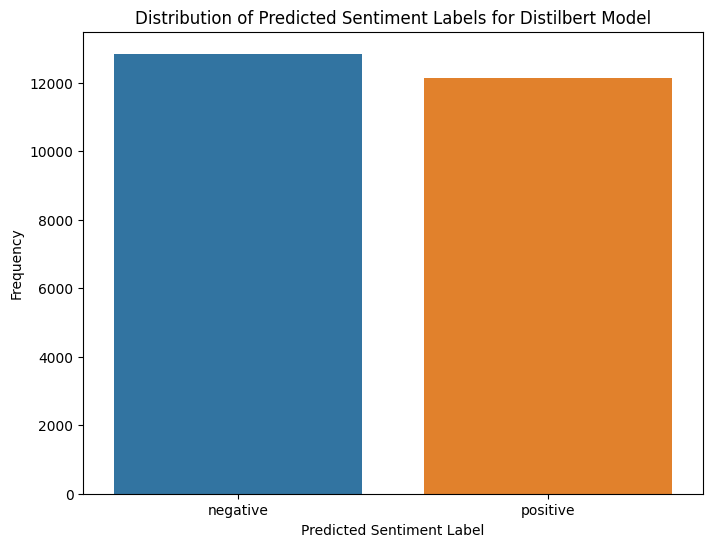

In [ ]:
test_df['predicted_sentiment'] = test_df['predicted_sentiment'].astype('category')
# Create a bar chart to visualize the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=test_df['predicted_sentiment'].value_counts().index, y=test_df['predicted_sentiment'].value_counts().values)
plt.xlabel('Predicted Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Sentiment Labels for Distilbert Model')
plt.show()

## 3. **Roberta  Model**

In [ ]:
# Already predicted sentiments added to 'predicted_sentiment' column
selected_columns = ['review_file', 'predicted_sentiment']
result_df = test_df.loc[:, selected_columns]

# Display 'result_df' contents of only the 'review_file' and 'predicted_sentiment' columns
print('Roberta Model:  Predicted Sentiments on Test Data')
print('==============================================')
result_df.head(50)

Roberta Model:  Predicted Sentiments on Test Data


,review_file,predicted_sentiment
0,0_10.txt,positive
1,0_2.txt,negative
2,10000_4.txt,negative
3,10000_7.txt,positive
4,10001_1.txt,negative
5,10001_9.txt,positive
6,10002_3.txt,negative
7,10002_8.txt,positive
8,10003_3.txt,negative
9,10003_8.txt,positive


# Distribution of predicted_sentiment for Roberta model

In [ ]:
# Calculate the frequency of each predicted sentiment label
sentiment_counts = test_df['predicted_sentiment'].value_counts()
sentiment_counts

positive    12997
negative    12003
Name: predicted_sentiment, dtype: int64

# Visualization of sentiment_counts for Roberta Model

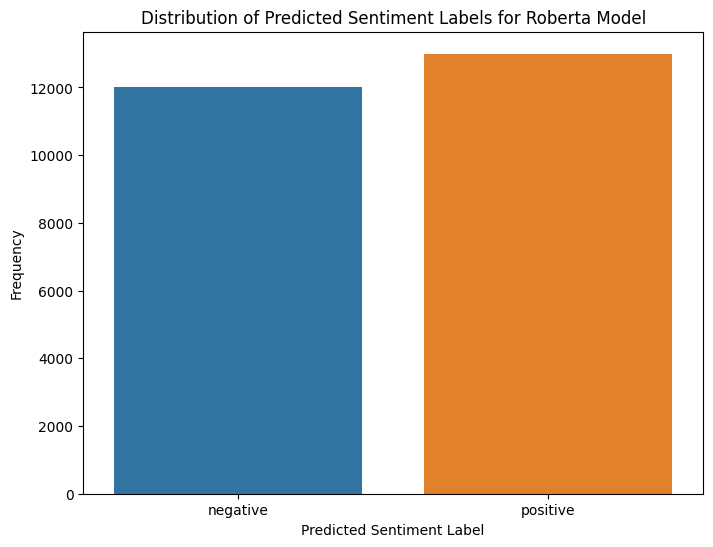

In [ ]:
test_df['predicted_sentiment'] = test_df['predicted_sentiment'].astype('category')
# Create a bar chart to visualize the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=test_df['predicted_sentiment'].value_counts().index, y=test_df['predicted_sentiment'].value_counts().values)
plt.xlabel('Predicted Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Sentiment Labels for Roberta Model')
plt.show()

# Hypothesis test for the 3 models:

To make statistical inferences from the results of the three models with test_df dataset and determine if there are statistically significant differences in performance between the three models (Bert, Distilbert, and Roberta), we shall perform a hypothesis test. The common statistical test for comparing proportions or success rates between two or more groups is the chi-squared test (χ² test). In our case, you want to compare the proportions of positive and negative predictions made by each model.

So we shall formulate our hypothesis as follows:

  1. **Null Hypothesis (Ho)**: There is NO significant difference between the models
  2. **Alternative Hypothesis (H1)**: There is significant difference between the models

## Create a DataFrame with the data from the model results:

In [5]:
models_data = {
    "Model": ["Bert", "Distilbert", "Roberta"],
    "Positive": [13193, 12152, 12997],
    "Negative": [11807, 12848, 12003]
}

df = pd.DataFrame(models_data)



## Perform the chi-squared test:

The code below is explained:
1. **Creating a Contingency Table**

  *observed = df[["Positive", "Negative"]].values*

  - In this line, we extract the "Positive" and "Negative" columns from the DataFrame df and store them as a NumPy array in the variable observed.
  - The observed array now contains the observed frequencies of positive and negative predictions for each model.
2. **Performing the Chi-Squared Test:**

  *chi2, p, _, _ = chi2_contingency(observed)*

  - We use the chi2_contingency function from the scipy.stats library to perform the chi-squared test on the observed frequencies.
  - The function returns four values:
    - chi2: The chi-squared statistic, which measures the degree of association between the observed and expected frequencies. It quantifies how much the actual data deviates from what would be expected if there were no association between the variables.
    - p: The p-value associated with the chi-squared statistic. It indicates the probability of observing such an extreme chi-squared statistic by chance if there were no association between the variables.
    - _: Ignored values (not used in this code).
    - _: Ignored values (not used in this code).
3. **Calculating Degrees of Freedom:**

  <i>degrees_of_freedom = (observed.shape[0] - 1) * (observed.shape[1] - 1)</i>

  - We calculate the degrees of freedom for the chi-squared test. Degrees of freedom are a measure of the number of values in the final calculation of a statistic that are free to vary. In this case, it depends on the dimensions of the contingency table.
4. **Printing the Results:**

  *print(f"Chi-squared statistic: {chi2:.2f}")*

  *print(f"P-value: {p:.4f}")*
  
  *print(f"Degrees of freedom: {degrees_of_freedom}")*

  - These lines print out the results of the chi-squared test. You'll see the chi-squared statistic, the p-value, and the degrees of freedom displayed.
5. **Interpret the Results:**

  *alpha = 0.05  # Set the significance level*

  *if p < alpha:*

      *print("There is evidence of a significant difference between the models.")*

  *else:*

      *print("There is no evidence of a significant difference between the models.")*

  - In this part, we set a significance level (alpha) typically to 0.05, which represents the threshold for statistical significance. We then compare the p-value (p) obtained from the chi-squared test to alpha. If p is less than alpha, we conclude that there is evidence of a significant difference between the models. Otherwise, if p is greater than or equal to alpha, we conclude that there is no evidence of a significant difference between the models.





In [6]:
# Create a contingency table (observed frequencies)
observed = df[["Positive", "Negative"]].values

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(observed)

# Degrees of freedom
degrees_of_freedom = (observed.shape[0] - 1) * (observed.shape[1] - 1)

# Print the results
print(f"Chi-squared statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# Interpret the results
alpha = 0.05  # Set the significance level
if p < alpha:
    print("There is evidence of a significant difference between the models.")
else:
    print("There is no evidence of a significant difference between the models.")

Chi-squared statistic: 97.98
P-value: 0.0000
Degrees of freedom: 2
There is evidence of a significant difference between the models.


# Conclusion
**From the result,  we therefore reject the Null hypothesis and accept the Alternative Hypothesis (H1): hat there is significant difference between the models. Meaning that each model behaves differently when predicting the sentiments.**